# A quick Start for Unet Model Understanding


## Data Exploring


In [1]:
!pip install opencv-python

In [2]:
!pip install segmentation-models

In [3]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-w13_2i1o
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-w13_2i1o
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [4]:
# Data Visualisation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm


from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split

# Segmentation Models
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

2023-12-06 16:21:35.669428: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 16:21:36.113631: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 16:21:36.249637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gargantua/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/../../lib64

Segmentation Models: using `keras` framework.


In [5]:
images = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/images"
tr_lab = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/labels/train"


edr = images + "/edr"
#mxy = images + "/mxy" # not required
#rng = images + "/rng-30m" # not required

In [6]:

edr_files = os.listdir(edr)
trlab_files = os.listdir(tr_lab)

X = []
y = []
c = 0

# preparing X and y
for lab_name in trlab_files:
    img_name = lab_name[:-4] + ".JPG"
    
    if img_name in edr_files:
        
        img_path = os.path.join(edr, img_name)
        img_arr = cv2.imread(img_path)
        img_arr = cv2.resize(img_arr, dsize = (256, 256))
        
        lab_path = os.path.join(tr_lab, lab_name)
        lab_arr = cv2.imread(lab_path, 0)
        lab_arr = cv2.resize(lab_arr, (256, 256), interpolation = cv2.INTER_NEAREST)
        
        X.append(img_arr)
        y.append(lab_arr)
        
    c += 1
    if c >= 500:
        break
        
X = np.asarray(X, dtype = np.float32) / 255.0
y = np.array(y, dtype = np.uint8)

# 0 - soil
# 1 - bedrock
# 2 - sand
# 3 - big rock
# 255 -> 4 - NULL (no label)


# keeping integer values in labels will help us in segmentation task (UNet)
y[y==255] = 4

print(X.shape, y.shape)


(498, 256, 256, 3) (498, 256, 256)


[1 2 4]


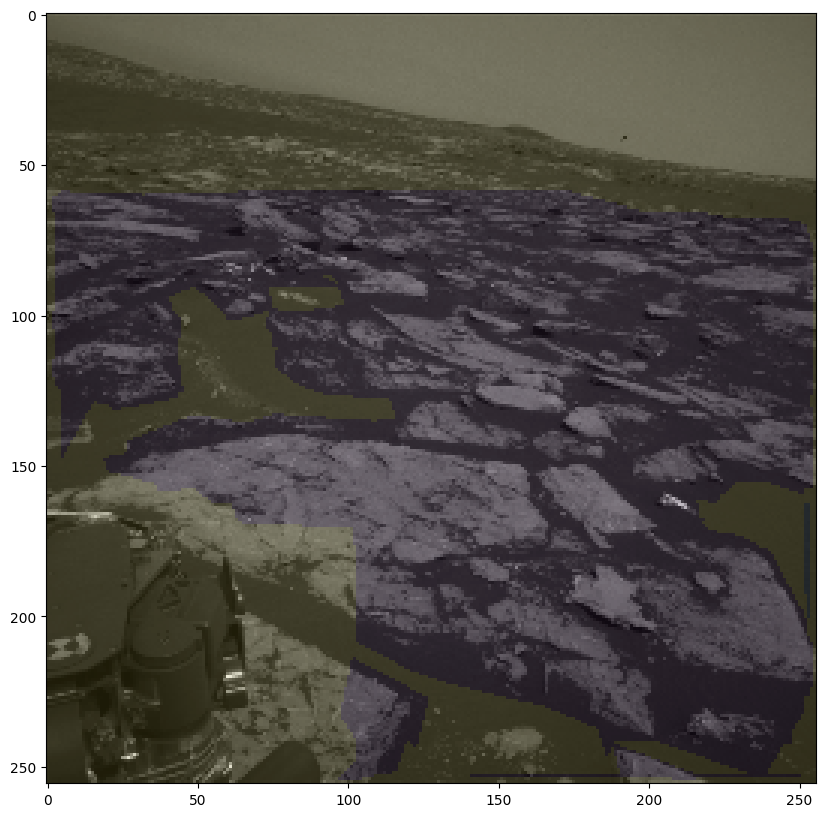

In [7]:
print(np.unique(y[255]))

plt.figure(figsize = (10, 10))

plt.imshow(X[255])
plt.imshow(y[255], alpha = 0.1)

plt.show()

In [8]:
n_classes=5 
height=256 
width=256 
channels=3
inputs = Input((height, width, channels))

#Down Sampling
conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
conv_1 = Dropout(0.1)(conv_1)  
conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_1)
    
conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_1)
conv_2 = Dropout(0.1)(conv_2)  
conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_2)
pool_2 = MaxPooling2D((2, 2))(conv_2)
     
conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_2)
conv_3 = Dropout(0.1)(conv_3)
conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_3)
pool_3 = MaxPooling2D((2, 2))(conv_3)
     
conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_3)
conv_4 = Dropout(0.1)(conv_4)
conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_4)
pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)
     
conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_4)
conv_5 = Dropout(0.2)(conv_5)
conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_5)

#Up Sampling
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv_5)
u6 = concatenate([u6, conv_4])
conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
conv_6 = Dropout(0.2)(conv_6)
conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_6)
     
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv_6)
u7 = concatenate([u7, conv_3])
conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
conv_7 = Dropout(0.1)(conv_7)
conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_7)
     
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv_7)
u8 = concatenate([u8, conv_2])
conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
conv_8 = Dropout(0.2)(conv_8)  
conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_8)
     
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv_8)
u9 = concatenate([u9, conv_1], axis=3)
conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
conv_9 = Dropout(0.1)(conv_9)
conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_9)
     
outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv_9)
    
model = Model(inputs=[inputs], outputs=[outputs])
model.summary()




2023-12-06 16:21:52.327889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gargantua/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/../../lib64:
2023-12-06 16:21:52.328770: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-06 16:21:52.328806: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Jinjin): /proc/driver/nvidia/version does not exist
2023-12-06 16:21:52.329932: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [24]:
model.compile(optimizer='adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score]) 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [11]:
num_classes = 5

# Création d'une liste vide pour stocker les masques
mask_list = []

for i in range(1, num_classes + 1):  # Assurez-vous que les classes commencent à 1
    mask = (y_train == i).astype(np.float32)  # Crée un masque pour chaque classe
    mask_list.append(mask)

# Empilage des masques pour former 5 canaux
y_train = np.stack(mask_list, axis=-1)

In [12]:
"""
%%time
es = callbacks.EarlyStopping(patience=2,restore_best_weights=True)
#modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format('First_model'), monitor="val_loss", verbose=0, save_best_only=False)


history = model.fit(X_train, y_train,
          batch_size=16,
          epochs=3,
          validation_split=0.3,
          callbacks=[es],
          verbose=1)  
"""

'\n%%time\nes = callbacks.EarlyStopping(patience=2,restore_best_weights=True)\n#modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format(\'First_model\'), monitor="val_loss", verbose=0, save_best_only=False)\n\n\nhistory = model.fit(X_train, y_train,\n          batch_size=16,\n          epochs=3,\n          validation_split=0.3,\n          callbacks=[es],\n          verbose=1)  \n'

In [13]:
"""
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.title('Train loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    
plot_history(history)
"""

"\ndef plot_history(history):\n    plt.plot(history.history['loss'])\n    plt.title('Train loss')\n    plt.ylabel('Loss')\n    plt.xlabel('Epoch')\n    plt.show()\n    \nplot_history(history)\n"

In [14]:
"""
%%time
es = callbacks.EarlyStopping(patience=2,restore_best_weights=True)
#modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format('First_model'), monitor="val_loss", verbose=0, save_best_only=False)


history = model.fit(X_train, y_train,
          batch_size=16,
          epochs=10,
          validation_split=0.3,
          callbacks=[es],
          verbose=1)  
"""

Epoch 1/10
16/16 [==============================] - 26s 1s/step - loss: 1.4578 - iou_score: 0.0815 - val_loss: 1.2656 - val_iou_score: 0.0958
Epoch 2/10
16/16 [==============================] - 23s 1s/step - loss: 1.2874 - iou_score: 0.1014 - val_loss: 1.2581 - val_iou_score: 0.0978
Epoch 3/10
16/16 [==============================] - 24s 2s/step - loss: 1.2503 - iou_score: 0.1036 - val_loss: 1.2078 - val_iou_score: 0.1063
Epoch 4/10
16/16 [==============================] - 24s 2s/step - loss: 1.2265 - iou_score: 0.1115 - val_loss: 1.1993 - val_iou_score: 0.1112
Epoch 5/10
16/16 [==============================] - 24s 2s/step - loss: 1.2203 - iou_score: 0.1126 - val_loss: 1.2105 - val_iou_score: 0.1098
Epoch 6/10
16/16 [==============================] - 24s 1s/step - loss: 1.2093 - iou_score: 0.1202 - val_loss: 1.1699 - val_iou_score: 0.1257
Epoch 7/10
16/16 [==============================] - 24s 2s/step - loss: 1.1916 - iou_score: 0.1295 - val_loss: 1.1409 - val_iou_score: 0.1381
Epoch 

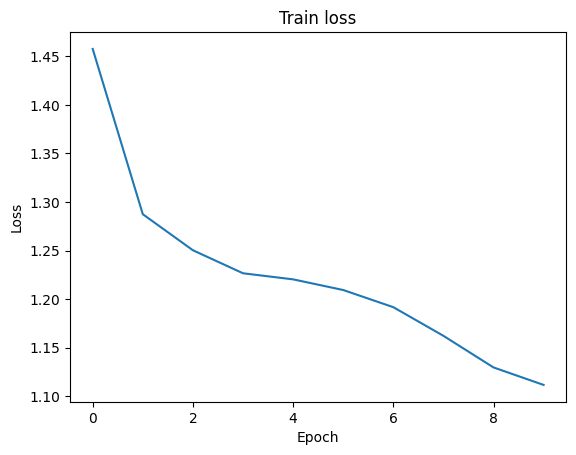

In [15]:
"""
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.title('Train loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    
plot_history(history)
"""

In [25]:
%%time
es = callbacks.EarlyStopping(patience=2,restore_best_weights=True)
#modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format('First_model'), monitor="val_loss", verbose=0, save_best_only=False)


history = model.fit(X_train, y_train,
          batch_size=16,
          epochs=100,
          validation_split=0.3,
          callbacks=[es],
          verbose=1)  

Epoch 1/100
16/16 [==============================] - 24s 1s/step - loss: 1.1298 - iou_score: 0.1686 - val_loss: 1.1122 - val_iou_score: 0.1594
Epoch 2/100
16/16 [==============================] - 21s 1s/step - loss: 1.0876 - iou_score: 0.1826 - val_loss: 1.1037 - val_iou_score: 0.1642
Epoch 3/100
16/16 [==============================] - 21s 1s/step - loss: 1.0782 - iou_score: 0.1859 - val_loss: 1.1144 - val_iou_score: 0.1632
Epoch 4/100
16/16 [==============================] - 22s 1s/step - loss: 1.0691 - iou_score: 0.1947 - val_loss: 1.1006 - val_iou_score: 0.1652
Epoch 5/100
16/16 [==============================] - 22s 1s/step - loss: 1.0615 - iou_score: 0.1987 - val_loss: 1.0589 - val_iou_score: 0.1860
Epoch 6/100
16/16 [==============================] - 22s 1s/step - loss: 1.0442 - iou_score: 0.2079 - val_loss: 1.0723 - val_iou_score: 0.1840
Epoch 7/100
16/16 [==============================] - 22s 1s/step - loss: 1.0355 - iou_score: 0.2171 - val_loss: 1.0453 - val_iou_score: 0.1932

In [26]:
history.history

{'loss': [1.1297701597213745,
  1.0876463651657104,
  1.0782088041305542,
  1.0690951347351074,
  1.0615358352661133,
  1.0441967248916626,
  1.0354652404785156,
  1.0449689626693726,
  1.0198251008987427],
 'iou_score': [0.1685541868209839,
  0.18260574340820312,
  0.18585895001888275,
  0.19469091296195984,
  0.19866147637367249,
  0.20785057544708252,
  0.2171015739440918,
  0.2078864872455597,
  0.21589668095111847],
 'val_loss': [1.1121928691864014,
  1.1037356853485107,
  1.1143794059753418,
  1.1005871295928955,
  1.0588997602462769,
  1.0723048448562622,
  1.04526686668396,
  1.0609480142593384,
  1.080163836479187],
 'val_iou_score': [0.15940341353416443,
  0.1642206758260727,
  0.16320741176605225,
  0.16516396403312683,
  0.18596236407756805,
  0.18400494754314423,
  0.1931913048028946,
  0.1878410279750824,
  0.17755672335624695]}

<function matplotlib.pyplot.show(close=None, block=None)>

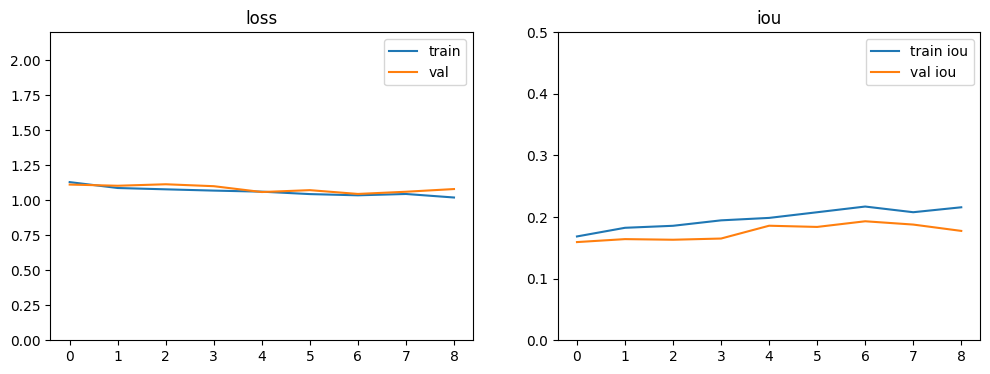

In [27]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['iou_score'], label='train iou'  + exp_name)
    ax2.plot(history.history['val_iou_score'], label='val iou'  + exp_name)
    ax2.set_ylim(0, 0.5)
    ax2.set_title('iou')
    ax2.legend()
    return (ax1, ax2)

plot_history(history)
plt.show